# Run through of `secdetect` package parameter space
---

In [1]:
from pathlib import Path
import random
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.set_cmap('magma');
%matplotlib inline

from skimage import img_as_float, img_as_bool
from skimage.io import imread
from skimage import morphology
from skimage import feature
from skimage import transform
from skimage import segmentation
from skimage import measure
from skimage import color
from skimage import exposure
from skimage import draw
from skimage import util

import secdetect

In [2]:
image = secdetect.data.load(11)

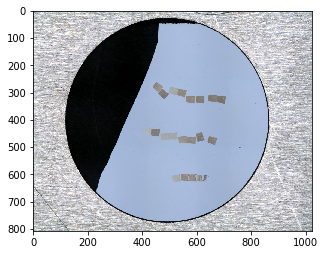

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image);

## Preprocessing
---
### (Down)Scale

In [4]:
# TODO: downscale
# or maybe not...

### Enhance contrast

In [5]:
# Default behavior
out1 = secdetect.enhance_contrast(image)
# Pull B channel
out2 = secdetect.enhance_contrast(image, channel=2)
# Give hed convolution matrix
out3 = secdetect.enhance_contrast(image, conv_matrix=color.hed_from_rgb)
# Give hed convolution matrix and pull DAB channel
out4 = secdetect.enhance_contrast(image, channel=2, conv_matrix=color.hed_from_rgb)

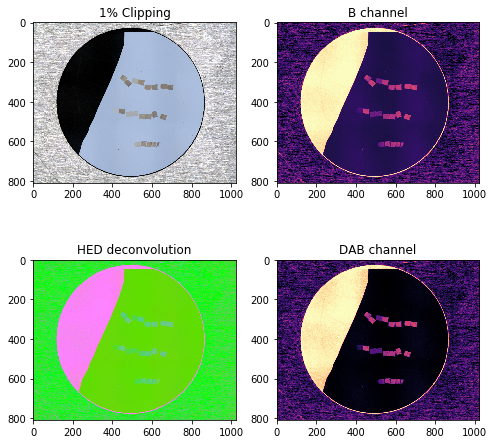

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
ax = axes.ravel()
ax[0].imshow(out1);
ax[1].imshow(-1*out2);
ax[2].imshow(out3)
ax[3].imshow(out4);

ax[0].set_title('1% Clipping');
ax[1].set_title('B channel');
ax[2].set_title('HED deconvolution');
ax[3].set_title('DAB channel');

## Ring Detection
### Canny edge detector
Canny edge detector requires grayscale

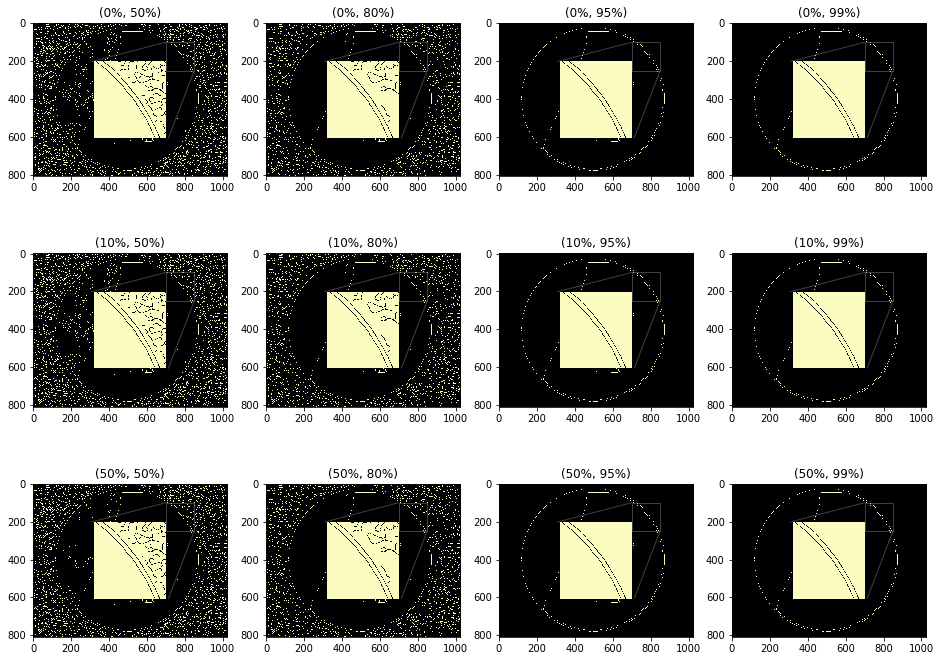

In [7]:
# DAB channel
in4 = secdetect.enhance_contrast(image, channel=2, conv_matrix=color.hed_from_rgb)

# Thresholds
low_thresholds = [0, 0.1, 0.5]
high_thresholds = [0.5, 0.8, 0.95, 0.99]
# Cartesian product
thresholds = np.array(np.meshgrid(low_thresholds, high_thresholds)).T.reshape(-1, 2)

# Plot
ncols = 4
nrows = int(np.ceil(len(thresholds) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for t, ax in zip(thresholds, axes.flat):
    
    out = feature.canny(in4, sigma=4, low_threshold=t[0], high_threshold=t[1], use_quantiles=True)
    ax.imshow(out)
    
    # Inset
    iax = ax.inset_axes([0.25, 0.25, 0.5, 0.5])
    iax.imshow(-1*out)
    iax.set_xlim(700, 850)
    iax.set_ylim(250, 100)
    ax.indicate_inset_zoom(iax)
    iax.axis('off')
    
    # Aesthetics
    title = f'({t[0]:.0%}, {t[1]:.0%})'
    ax.set_title(title)

### Find ring

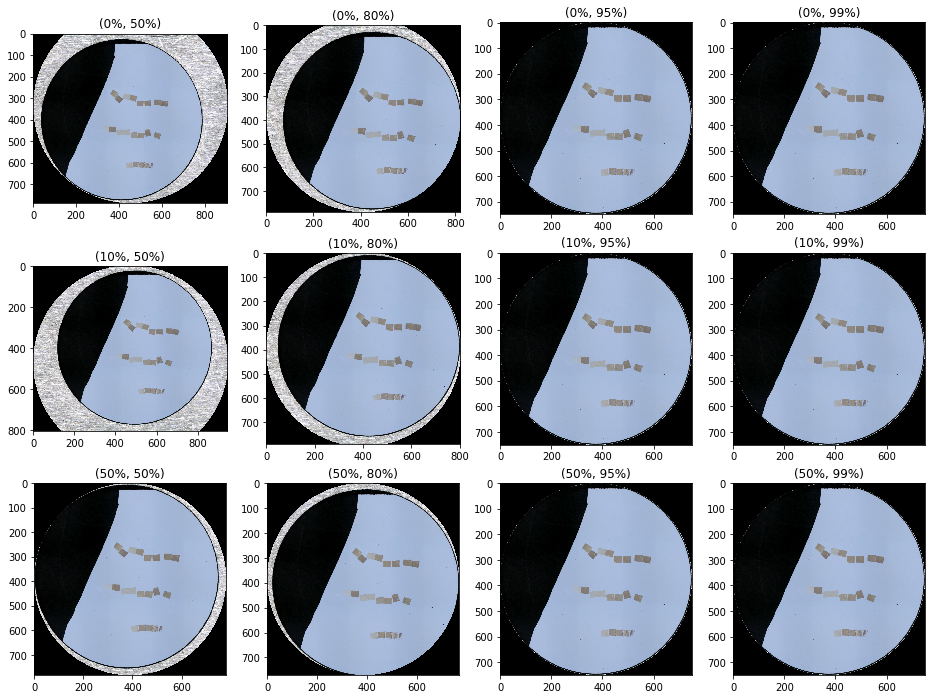

In [8]:
# RANSAC parameters
ransac_kws = {'min_samples': 3,
              'residual_threshold': 1,
              'max_trials': 250}
# Plot
ncols = 4
nrows = int(np.ceil(len(thresholds) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for t, ax in zip(thresholds, axes.flat):
    # Find and crop to ring
    edges = feature.canny(in4, sigma=4, low_threshold=t[0], high_threshold=t[1], use_quantiles=True)
    params = secdetect.find_ring(edges, ransac_kws=ransac_kws)
    out = secdetect.crop_to_ring(image.copy(), *params)
    # Plot
    ax.imshow(out)
    
    # Aesthetics
    title = f'({t[0]:.0%}, {t[1]:.0%})'
    ax.set_title(title)

## Segmentation
---

In [9]:
# Enhance contrast
enhanced = secdetect.enhance_contrast(image, channel=2, conv_matrix=color.hed_from_rgb)
# Canny edge detection
low_threshold = 0.1
high_threshold = 0.99
edges = feature.canny(enhanced, sigma=4, low_threshold=low_threshold,
                      high_threshold=high_threshold, use_quantiles=True)
# Find ring
cx, cy, r = secdetect.find_ring(edges)
# Crop to ring
preprocessed = secdetect.crop_to_ring(image, cx=cx, cy=cy, radius=r)

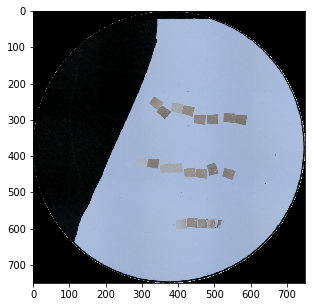

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(preprocessed);

### Felzenswalb

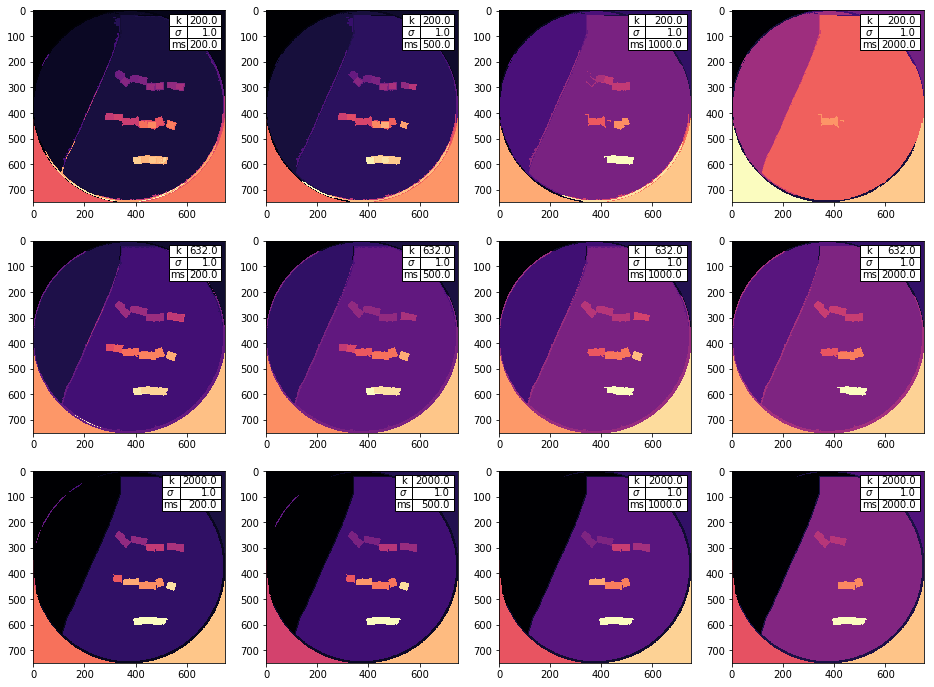

In [11]:
scales = np.logspace(np.log10(200), np.log10(2000), 3).round()
sigmas = [1.0]
min_sizes = [200, 500, 1000, 2000]
felzenszwalb_kws = np.array(np.meshgrid(scales, min_sizes, sigmas)).T.reshape(-1, 3)

# Plot
ncols = 4
nrows = int(np.ceil(len(felzenszwalb_kws) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for fzkw, ax in zip(felzenszwalb_kws, axes.flat):
    # Segmentation
    scale, min_size, sigma = fzkw
    out = segmentation.felzenszwalb(preprocessed, scale, sigma, int(min_size))
    # Plot segmentation
    ax.imshow(out)
    # Parameter table
    df = pd.DataFrame([scale, sigma, min_size])
    tab = ax.table(cellText=df.values, rowLabels=['k', '$\sigma$', 'ms'],
                   rowLoc='center',
                   loc='upper right', zorder=1)
    tab.auto_set_column_width(0)

### Felzenswalb + border removal

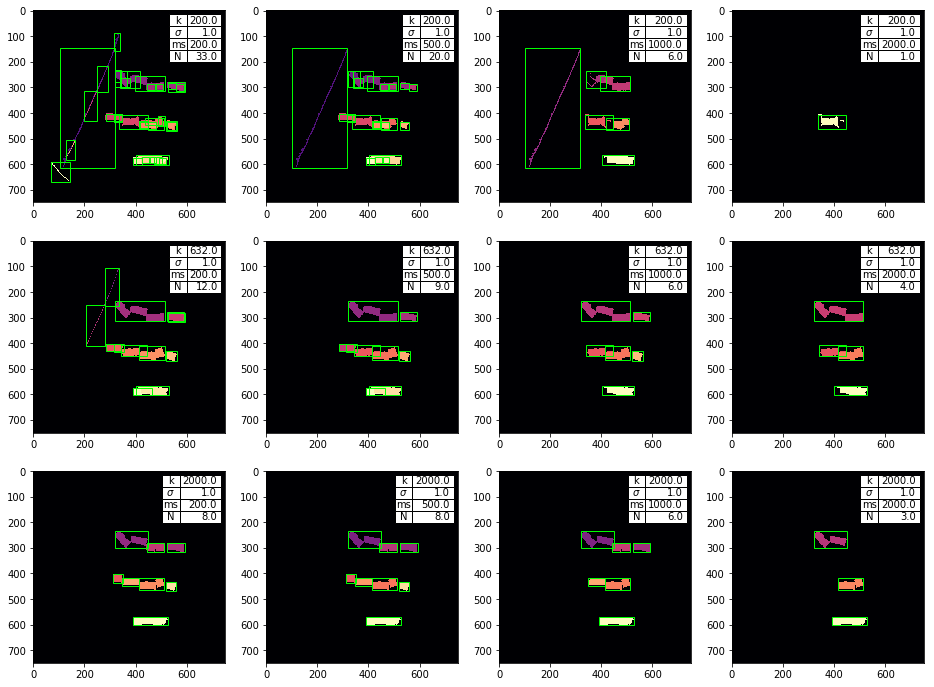

In [12]:
# Plot
ncols = 4
nrows = int(np.ceil(len(felzenszwalb_kws) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for fzkw, ax in zip(felzenszwalb_kws, axes.flat):
    # Segmentation
    scale, min_size, sigma = fzkw
    imfz = segmentation.felzenszwalb(preprocessed, scale, sigma, int(min_size))
    out = segmentation.clear_border(imfz, buffer_size=50)
    
    # Labels and regions
    labels = measure.label(out)
    for region in measure.regionprops(labels):
        y0, x0, y1, x1 = region.bbox
        r = Rectangle((x0, y0), x1-x0, y1-y0, fill=False,
                      edgecolor='#00FF00', lw=1)
        ax.add_patch(r)
    
    # Plot binary segmentation
    ax.imshow(out)
    # Parameter table
    df = pd.DataFrame([scale, sigma, min_size, labels.max()])
    tab = ax.table(cellText=df.values, rowLabels=['k', '$\sigma$', 'ms', 'N'],
                   rowLoc='center',
                   loc='upper right', zorder=1)
    tab.auto_set_column_width(0)